# Train RNN on extracted features or images.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import time
import os.path
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import class_weight

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.layers import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.utils.np_utils import to_categorical  

import tensorflow as tf

In [5]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
fps = '2FPS'
frame_dir = '../../data/DAiSEE/' + fps + '/data/'
features_dir = os.getcwd() + '/features/' 
usage = ['Train', 'Test', 'Validation']

model_dir = '../../data/models/lstm/'

In [7]:
# Get features
X_train = np.load(features_dir + 'train_features.npy') 
y_train = np.load(features_dir + 'train_labels.npy') 

X_val = np.load(features_dir + 'val_features.npy') 
y_val = np.load(features_dir + 'val_labels.npy') 

In [8]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(107160, 1280) (107160,)
(28580, 1280) (28580,)


In [9]:
print(X_train.shape[0]/20)
print(X_val.shape[0]/20)

5358.0
1429.0


In [11]:
X_train = X_train.reshape(int(X_train.shape[0]/20), 20, 1280)
X_val = X_val.reshape(int(X_val.shape[0]/20), 20, 1280)

In [12]:
# split the labels into per video classifier
y_train = y_train[1::20]
y_val = y_val[1::20]

In [13]:
y_train = to_categorical(y_train, num_classes=4)

In [14]:
y_val = to_categorical(y_val, num_classes=4)

In [15]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(5358, 20, 1280) (5358, 4)
(1429, 20, 1280) (1429, 4)


In [16]:
model = 'lstm'
seq_length = 20

features_length = X_train.shape[2]
data_type = 'features'

saved_model = None  # None or weights file
load_to_memory = False  # pre-load the sequences into memory
batch_size = 32
epochs = 100 

input_shape = (seq_length, features_length)

In [17]:
print(input_shape)

(20, 1280)


In [48]:
# call backs

# save checkpoint
timestr = time.strftime("%Y%m%d-%H%M%S")
best_model_file = model_dir + 'LSTM_' + timestr + '_{epoch}.hdf5'

checkpoint = ModelCheckpoint(best_model_file,
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# early stopping callback
early_stopping = EarlyStopping(monitor='accuracy', patience=4, verbose=1, mode='auto')   

callbacks = [checkpoint, early_stopping]

In [49]:
model = Sequential()
model.add(LSTM(units=2048, input_shape=(20,1280),
               return_sequences=False,
               dropout=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2048)              27271168  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 28,322,308
Trainable params: 28,322,308
Non-trainable params: 0
_________________________________________________________________


In [51]:
optimizer = Adam(lr=1e-5, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [52]:
history = model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=callbacks,
          epochs=epochs)

Epoch 1/100
168/168 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.4879
Epoch 00001: accuracy improved from -inf to 0.48787, saving model to ../../data/models/lstm/LSTM_20201205-094352_1.hdf5
168/168 [==============================] - 4s 24ms/step - loss: 1.0961 - accuracy: 0.4879 - val_loss: 1.3712 - val_accuracy: 0.3464
Epoch 2/100
165/168 [============================>.] - ETA: 0s - loss: 1.0355 - accuracy: 0.5199
Epoch 00002: accuracy improved from 0.48787 to 0.52016, saving model to ../../data/models/lstm/LSTM_20201205-094352_2.hdf5
168/168 [==============================] - 4s 21ms/step - loss: 1.0354 - accuracy: 0.5202 - val_loss: 1.3373 - val_accuracy: 0.3555
Epoch 3/100
165/168 [============================>.] - ETA: 0s - loss: 1.0077 - accuracy: 0.5333
Epoch 00003: accuracy improved from 0.52016 to 0.53378, saving model to ../../data/models/lstm/LSTM_20201205-094352_3.hdf5
168/168 [==============================] - 4s 21ms/step - loss: 1.0085 - accura

165/168 [============================>.] - ETA: 0s - loss: 0.7580 - accuracy: 0.6682
Epoch 00025: accuracy improved from 0.66163 to 0.66816, saving model to ../../data/models/lstm/LSTM_20201205-094352_25.hdf5
168/168 [==============================] - 4s 21ms/step - loss: 0.7567 - accuracy: 0.6682 - val_loss: 1.6376 - val_accuracy: 0.3534
Epoch 26/100
165/168 [============================>.] - ETA: 0s - loss: 0.7467 - accuracy: 0.6648
Epoch 00026: accuracy did not improve from 0.66816
168/168 [==============================] - 3s 17ms/step - loss: 0.7461 - accuracy: 0.6654 - val_loss: 1.6255 - val_accuracy: 0.3478
Epoch 27/100
165/168 [============================>.] - ETA: 0s - loss: 0.7416 - accuracy: 0.6699
Epoch 00027: accuracy improved from 0.66816 to 0.67133, saving model to ../../data/models/lstm/LSTM_20201205-094352_27.hdf5
168/168 [==============================] - 4s 21ms/step - loss: 0.7400 - accuracy: 0.6713 - val_loss: 1.6028 - val_accuracy: 0.3394
Epoch 28/100
165/168 [==

Epoch 75/100
165/168 [============================>.] - ETA: 0s - loss: 0.3753 - accuracy: 0.8400
Epoch 00075: accuracy improved from 0.83949 to 0.84099, saving model to ../../data/models/lstm/LSTM_20201205-094352_75.hdf5
168/168 [==============================] - 4s 21ms/step - loss: 0.3746 - accuracy: 0.8410 - val_loss: 2.5335 - val_accuracy: 0.2883
Epoch 76/100
165/168 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.8498
Epoch 00076: accuracy improved from 0.84099 to 0.85013, saving model to ../../data/models/lstm/LSTM_20201205-094352_76.hdf5
168/168 [==============================] - 4s 21ms/step - loss: 0.3648 - accuracy: 0.8501 - val_loss: 2.6851 - val_accuracy: 0.3121
Epoch 77/100
165/168 [============================>.] - ETA: 0s - loss: 0.3585 - accuracy: 0.8504
Epoch 00077: accuracy did not improve from 0.85013
168/168 [==============================] - 3s 17ms/step - loss: 0.3586 - accuracy: 0.8499 - val_loss: 2.6011 - val_accuracy: 0.3044
Epoch 78/10

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


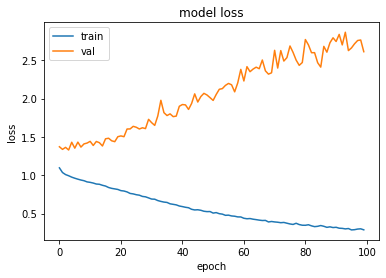

In [53]:
# Show graphs
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


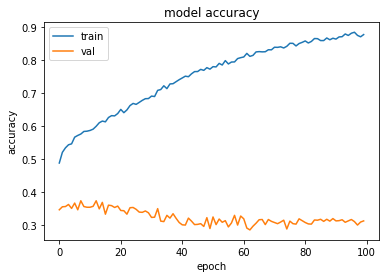

In [54]:
# Show graphs
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
# Get features
X_test = np.load(features_dir + 'test_features.npy') 
y_test = np.load(features_dir + 'test_labels.npy') 
X_test = X_test.reshape(int(X_test.shape[0]/20), 20, 1280)
y_test = y_test[1::20]
y_test = to_categorical(y_test, num_classes=4)
print(X_test.shape, y_test.shape)

(1784, 20, 1280) (1784, 4)


In [56]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test acc:', test_acc)

56/56 [==============================] - 0s 7ms/step - loss: 1.9603 - accuracy: 0.3823
test acc: 0.38228699564933777


In [57]:
predictions = model.predict(X_test)

In [58]:
y_pred = np.argmax(predictions, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [59]:
# print the report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.47      0.51      0.49       823
          1       0.33      0.39      0.35       584
          2       0.21      0.10      0.14       338
          3       0.00      0.00      0.00        39

avg / total       0.36      0.38      0.37      1784



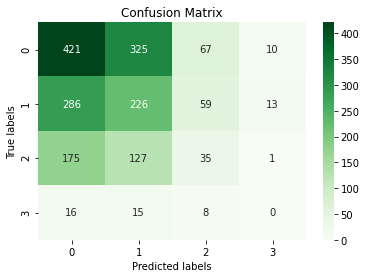

In [60]:
class_labels = [0,1,2,3]
cm = confusion_matrix(y_test, y_pred, class_labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_labels); ax.yaxis.set_ticklabels(class_labels);